In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet

import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

In [2]:
%run -i financial_sector_functions.py

/home/luke/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [34]:
data = pd.read_csv("financial_sector_clean_return_space_Dec_13.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)
sector_return = data.iloc[:,[0]]
x_data = data.iloc[:,1:]
sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

sector_beat_benchmark = pd.DataFrame((sector_return.values - sp500.values)*1,index = sector_return.index,columns = ['IFY beat benchmark'])

In [35]:
x = x_data
y = sector_beat_benchmark


In [62]:
def elastic_net_function(alpha_value,l1_value):
    regr = ElasticNet(alpha =alpha_value,l1_ratio=l1_value,fit_intercept=True)
    regr.fit(x, y)

    regr.coef_
    elastic_result = regr.predict(x)
    elastic_result = pd.DataFrame(elastic_result,index = y.index)
    accuracy_value = evaluate_metric(y,elastic_result,'r2')
    return accuracy_value

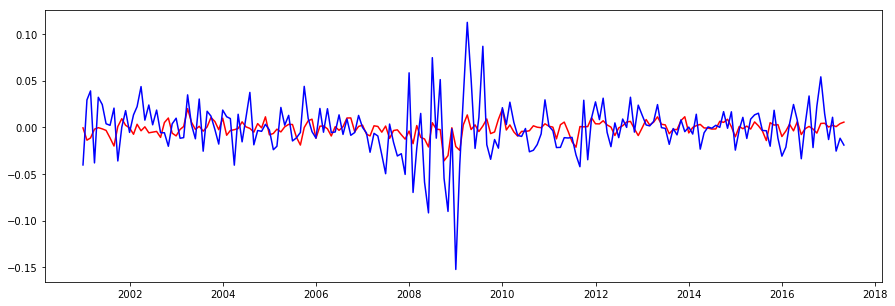

0.15612464986451469

In [64]:
regr = ElasticNet(alpha =0.001,l1_ratio=0.000001,fit_intercept=True)
regr.fit(x, y)

regr.coef_
elastic_result = regr.predict(x)
elastic_result = pd.DataFrame(elastic_result,index = y.index)
accuracy_value = evaluate_metric(y,elastic_result,'r2')

plt.figure(figsize = (15,5))
plt.plot(elastic_result,'r-')
plt.plot(y,'b-')
plt.show()
accuracy_value

In [38]:
map(lambda x: round(x,3),np.linspace(0.0005,0.1,7))

[0.001, 0.017, 0.034, 0.05, 0.067, 0.083, 0.1]

In [39]:
result_df = pd.DataFrame()
for alpha in map(lambda x: round(x,3),np.linspace(0.0005,0.05,7)):
    for l1 in np.linspace(0.001,0.5,10):
        acf_value = elastic_net_function(alpha,l1)
        result_df.loc["Penalty: "+str(round(alpha,3)),str(round(l1,3))] = acf_value

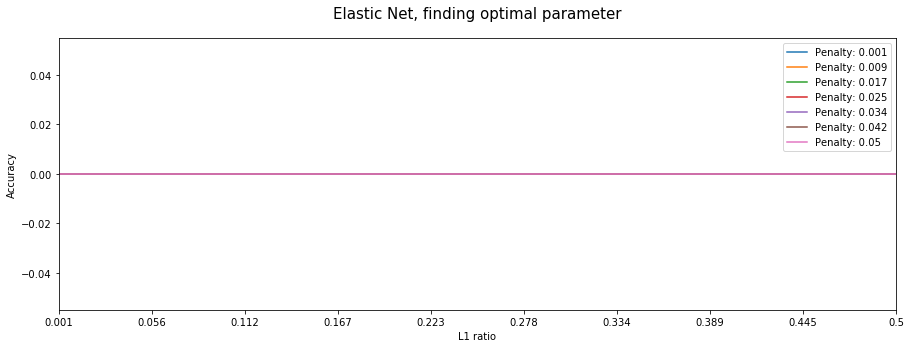

In [40]:
result_df.T.plot(figsize = (15,5))
plt.xlabel("L1 ratio")
plt.ylabel("Accuracy")
ttl = plt.title("Elastic Net, finding optimal parameter",fontsize = 15)
ttl.set_position([.5, 1.05])
plt.savefig("Elastic_regression_cant_beat_linear_reg.png")
plt.show()

In [ ]:
nunmber_of_years_lookback = 5
month_forecast = 3
lambda_value = 3.5


logistic_result_dict = {}
coef_all_df = pd.DataFrame()
accuracy_dict = {}
y_prediction_dict ={}
prob_dict ={}
number_of_runs = 0.0


elastic_result = [1.0 if prob>0.5 else 0.0 for prob in regr.predict(x)]
elastic_result = pd.DataFrame(elastic_result,index = y.index)
accuracy_value = evaluate_metric(y,elastic_result,'acf')



for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
    begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
    selection = (x.index>=begin_index) & (x.index <= end_index)
    spliced_x = x[selection]
    spliced_y = y[selection]

    assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
    regr = ElasticNet(alpha =alpha_value,l1_ratio=l1_value,fit_intercept=True)
    regr.fit(x, y)

    
    test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
    test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
    test_x = x[test_selection]
    test_y = y[test_selection]
    assert(len(test_y)==month_forecast)
    y_prediction = pd.DataFrame(logistic.predict(test_x),index = test_y.index,columns = test_y.columns)
    prb_values = [prob_list[1] for prob_list in logistic.predict_proba(test_x)]
    prob_dict[str(dt_index.date())]=pd.DataFrame(prb_values, index = test_y.index)
    y_prediction_dict[dt_index] = y_prediction
    accuracy_df = ((y_prediction-test_y)==0)*1
    accuracy_dict[str(dt_index.date())] = accuracy_df
    number_of_runs +=1
